
This notebook walks through the implementation and analysis of the Insider Trading Machine Learning Project. It walks through using the created dataset. The code for (1) pulling Form 4 data from EDGAR and (2) creating the dataset is in sec_crawler.py and create_dataset.py, respectively.

To start we load the dataset into a Pandas Dataframe.

In [2]:
import numpy as np
import pandas as pd

dataset = pd.read_csv("dataset.csv")

Next, we conduct some simple data preprocessing. First we drop missing datapoints ('None': points for which data is was not available, 'Fail': points for which stock price data was missing, and any NaN values). We also drop the COMPANY ticker and MONTH columns, and cleanup the market cap category data. While we gathered return data for 1 (RET1), 6 (RET6), and 12 (RET12) months, we are only using RET6 data in this demo since this data provided the best results. We renamed RET6 as RET.

We then define a use a count_zereos() function to eliminate datapoint that have too many zeroes (e.g., for companies that didn't buy or sell any stock for an entire year), since these point do not provide meaningful data.

Finally, we define a function to separate the non-binary discrete variables into multiple binary variables using the get_dummies function. We use this function later on to split market sector data into 10 binary variables, and market cap data into 3 binary variables.


In [3]:
#Cleanup dataset
dataset = dataset[dataset.RET1 != 'None']
dataset = dataset[dataset.RET1 != 'Fail']
dataset = dataset[dataset.RET6 != 'None']
dataset = dataset[dataset.RET6 != 'Fail']
dataset = dataset[dataset.RET12 != 'None']
dataset = dataset[dataset.RET12 != 'Fail']
dataset.dropna(axis=0, inplace=True)
dataset = dataset.drop(['COMPANY'], axis=1)
dataset = dataset.drop(['MONTH'], axis=1)
dataset = dataset.drop(['RET1'], axis=1)
dataset = dataset.drop(['RET12'], axis=1)
dataset.rename(index=str, columns={'RET6': 'RET'}, inplace=True)
dataset['MKTCAP'].replace('.*Small.', 'small', inplace=True, regex=True)
dataset['MKTCAP'].replace('.*Mid.', 'mid', inplace=True, regex=True)
dataset['MKTCAP'].replace('.*Large.', 'large', inplace=True, regex=True)

#Count zeroes in the last six months of a 12 month period
def count_zeroes(x):
    count = 0
    for i in x[6:12]:
        if i == 0.0:
            count = count + 1
    return count

#removes points with 4 or more zero months in the last 6 months.
dataset = dataset[dataset.apply(lambda x: count_zeroes(x) < 3,axis=1)]

#Create binary variables for non-binary discrete variables
def preprocess_features(X):
    output = pd.DataFrame(index = X.index)
    for col, col_data in X.iteritems():
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
        output = output.join(col_data)
    return output



Below is a sample of the dataset for visualization purposes.

In [4]:
dataset.head()

,NBC1,NBC2,NBC3,NBC4,NBC5,NBC6,NBC7,NBC8,NBC9,NBC10,...,NBV6,NBV7,NBV8,NBV9,NBV10,NBV11,NBV12,SECTOR,MKTCAP,RET
11,0.000000,0.000000,0.000000,0.238095,0.714286,0.000000,0.000000,0.250000,0.0,-0.500000,...,-0.008877,-0.013989,-0.035092,-0.200000,-0.100703,-0.046731,-0.001233,Health Care,mid,0.0133544556951
12,0.000000,0.000000,0.238095,0.714286,0.000000,0.000000,0.250000,0.000000,-0.5,0.714286,...,-0.013989,-0.035092,-0.200000,-0.100703,-0.046731,-0.001233,-0.063833,Health Care,mid,0.00289269388017
20,-0.500000,0.714286,-0.200000,0.000000,0.000000,0.000000,0.238095,0.714286,0.0,-1.000000,...,-0.200000,-0.009034,-0.086717,0.000000,-1.000000,0.000000,1.000000,Health Care,mid,0.0337565695742
21,0.714286,-0.200000,0.000000,0.000000,0.000000,0.238095,0.714286,0.000000,-1.0,0.000000,...,-0.009034,-0.086717,0.000000,-1.000000,0.000000,1.000000,-0.111111,Health Care,mid,-0.0111431094477
22,-0.200000,0.000000,0.000000,0.000000,0.238095,0.714286,0.000000,-1.000000,0.0,1.000000,...,-0.086717,0.000000,-1.000000,0.000000,1.000000,-0.111111,1.000000,Health Care,mid,-0.00712147109318


# Statistics




The code below generates statistics on return, net buy count, and net buy volume across the dataset.

In [5]:
ret_data = dataset['RET'].apply(pd.to_numeric, errors='coerce')
min_return = np.min(ret_data)
max_return = np.max(ret_data)
mean_return = np.mean(ret_data)
median_return = np.median(ret_data)
std_return = np.std(ret_data)
fq_return = np.percentile(ret_data,25)
tq_return = np.percentile(ret_data,75)
ft_return = np.percentile(ret_data,33)
st_return = np.percentile(ret_data,66)
print "Min return: " + str(min_return)
print "Max return: " + str(max_return)
print "Mean return: " + str(mean_return)
print "Median return: " + str(median_return)
print "Std Dev of return: " + str(std_return)
print "First quartile: " + str(fq_return)
print "Third quartile: " + str(tq_return)
print "First third: " + str(ft_return)
print "Second third: " + str(st_return)

all_nbc = np.concatenate([dataset['NBC' + str(i)].apply(pd.to_numeric, errors='coerce') for i in range(1,13)])
min_nbc = min(all_nbc)
max_nbc = max(all_nbc)
mean_nbc = np.mean(all_nbc)
median_nbc = np.median(all_nbc)
std_nbc = np.std(all_nbc)
fq_nbc = np.percentile(all_nbc, 25)
tq_nbc = np.percentile(all_nbc, 75)
print "Min NBC: " + str(min_nbc)
print "Max NBC: " + str(max_nbc)
print "Mean NBC: " + str(mean_nbc)
print "Median NBC: " + str(median_nbc)
print "Std NBC: " + str(std_nbc)
print "FQ NBC: " + str(fq_nbc)
print "TQ NBC: " + str(tq_nbc)

all_nbv = np.concatenate([dataset['NBV' + str(i)].apply(pd.to_numeric, errors='coerce') for i in range(1,13)])
min_nbv = min(all_nbv)
max_nbv = max(all_nbv)
mean_nbv = np.mean(all_nbv)
median_nbv = np.median(all_nbv)
std_nbv = np.std(all_nbv)
fq_nbv = np.percentile(all_nbv, 25)
tq_nbv = np.percentile(all_nbv, 75)
print "Min NBV: " + str(min_nbv)
print "Max NBV: " + str(max_nbv)
print "Mean NBV: " + str(mean_nbv)
print "Median NBV: " + str(median_nbv)
print "Std NBV: " + str(std_nbv)
print "FQ NBV: " + str(fq_nbv)
print "TQ NBV: " + str(tq_nbv)


Min return: -0.867926289208
Max return: 6.66432449583
Mean return: 0.0138842243279
Median return: 0.00513197463559
Std Dev of return: 0.197127084811
First quartile: -0.0916451313919
Third quartile: 0.105930831069
First third: -0.0581371249263
Second third: 0.0647762819449
Min NBC: -1.0
Max NBC: 1.0
Mean NBC: -0.0476770981571
Median NBC: 0.0
Std NBC: 0.617138246484
FQ NBC: -0.444444444444
TQ NBC: 0.272727272727
Min NBV: -1.0
Max NBV: 1.0
Mean NBV: -0.0729720938819
Median NBV: -0.00623401420643
Std NBV: 0.57028647246
FQ NBV: -0.230769230769
TQ NBV: 0.0


A histogram of return data shows that the returns are roughly normally distributed.

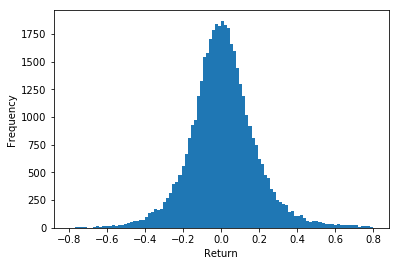

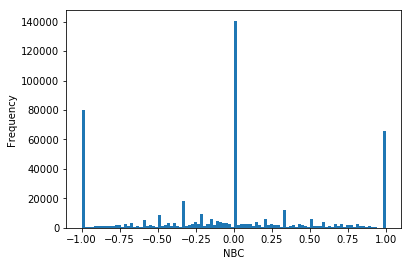

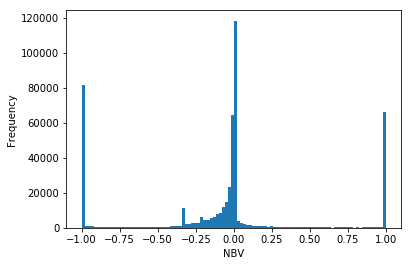

In [16]:
import matplotlib.pyplot as plt

plt.hist(ret_data, bins=100, range=(-.8,.8))
plt.ylabel('Frequency')
plt.xlabel('Return')
plt.show()

plt.hist(all_nbc, bins=100, range=(-1,1))
plt.ylabel('Frequency')
plt.xlabel('NBC')
plt.show()

plt.hist(all_nbv, bins=100, range=(-1,1))
plt.ylabel('Frequency')
plt.xlabel('NBV')
plt.show()